In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [2]:
import zipfile
with zipfile.ZipFile('Pneumonia.zip') as zipref:
    zipref.extractall('Pneumonia_Extracted')


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'Pneumonia_Extracted/chest_xray/chest_xray/train'
test_dir = 'Pneumonia_Extracted/chest_xray/chest_xray/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128), 
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    subset = 'training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128), 
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


NORMAL: 1073 images
PNEUMONIA: 3100 images


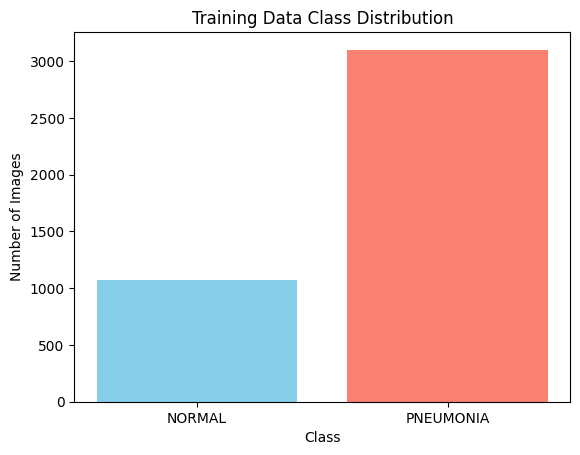

In [5]:
class_counts = Counter(train_generator.classes)
class_labels = list(train_generator.class_indices.keys())
for i, label in enumerate(class_labels):
    print(f"{label}: {class_counts[i]} images")

plt.bar(class_labels, [class_counts[i] for i in range(len(class_labels))], color=['skyblue', 'salmon'])
plt.title("Training Data Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


In [6]:
from sklearn.utils.class_weight import compute_class_weight
class_indices = train_generator.class_indices
labels = list(train_generator.classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: 1.9445479962721341, 1: 0.6730645161290323}


In [7]:
from PIL import Image
import os
sample_path = 'NormalvPneumonia/chest_xray/test/NORMAL/IM-0006-0001.jpeg'
img = Image.open(sample_path)
print(img.mode)


L


In [8]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
)

Epoch 1/40
131/131 [==============================] - 23s 173ms/step - loss: 0.1032 - accuracy: 0.9626 - val_loss: 0.1009 - val_accuracy: 0.9664
Epoch 2/40
131/131 [==============================] - 23s 174ms/step - loss: 0.1106 - accuracy: 0.9590 - val_loss: 0.1117 - val_accuracy: 0.9607
Epoch 3/40
131/131 [==============================] - 23s 173ms/step - loss: 0.0985 - accuracy: 0.9624 - val_loss: 0.0931 - val_accuracy: 0.9626
Epoch 4/40
131/131 [==============================] - 23s 172ms/step - loss: 0.0964 - accuracy: 0.9655 - val_loss: 0.1467 - val_accuracy: 0.9406
Epoch 5/40
131/131 [==============================] - 23s 172ms/step - loss: 0.1047 - accuracy: 0.9605 - val_loss: 0.1014 - val_accuracy: 0.9674
Epoch 6/40
131/131 [==============================] - 22s 169ms/step - loss: 0.0975 - accuracy: 0.9667 - val_loss: 0.0773 - val_accuracy: 0.9770
Epoch 7/40
131/131 [==============================] - 23s 175ms/step - loss: 0.1005 - accuracy: 0.9653 - val_loss: 0.0983 - val_ac

In [15]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")


20/20 [==============================] - 2s 78ms/step - loss: 0.4801 - accuracy: 0.8622
Test Accuracy: 0.8622


20/20 [==============================] - 2s 88ms/step


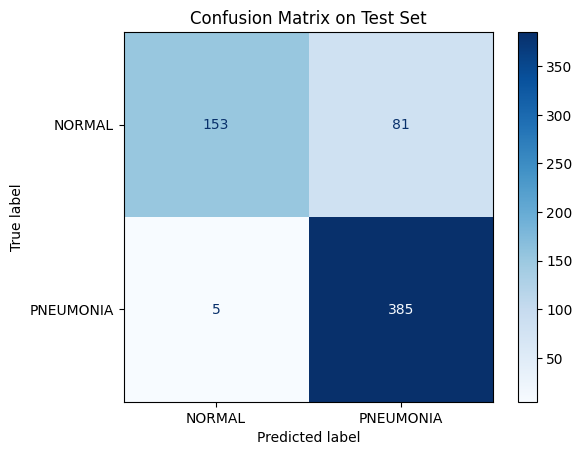

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.65      0.78       234
   PNEUMONIA       0.83      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624



In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

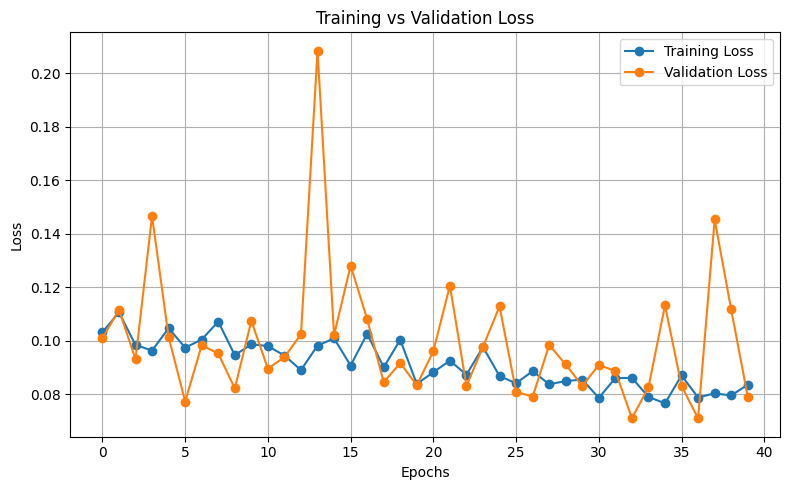

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
img_path = 'Pneumonia_Extracted/chest_xray/test/PNEUMONIA/person23_virus_56.jpeg'
img = image.load_img(img_path, target_size=(128, 128), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
if prediction[0][0] > 0.5:
    print("Prediction: Pneumonia")
else:
    print("Prediction: Normal")

1/1 [==============================] - 0s 21ms/step
Prediction: Pneumonia


In [19]:
img_path = 'Pneumonia_Extracted/chest_xray/test/NORMAL/IM-0010-0001.jpeg'
img = image.load_img(img_path, target_size=(128, 128), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
if prediction[0][0] > 0.5:
    print("Prediction: Pneumonia")
else:
    print("Prediction: Normal")

1/1 [==============================] - 0s 19ms/step
Prediction: Normal
